In [1]:
import pandas as pd
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tensorflow
from tensorflow import keras
from tqdm import tqdm
import pickle
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping
import keras.optimizers
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from keras.applications import vgg16
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
tensorflow.__version__

'2.1.0'

In [3]:
from tensorflow.python.client import device_lib

# List available GPU devices
physical_devices = tensorflow.config.list_physical_devices('GPU')
if physical_devices:
    try:
        # Set memory growth for the first GPU device
        tensorflow.config.set_logical_device_configuration(
            physical_devices[0],
            [tensorflow.config.LogicalDeviceConfiguration(memory_limit=4096)]
        )
        #tensorflow.config.experimental.set_memory_growth(physical_devices[0], True)
        #print("Memory growth enabled for GPU")
    except RuntimeError as e:
        # Memory growth must be set before any initialization
        print(e)
else:
    print("No GPU found")


# Enable GPU memory growth to avoid memory allocation errors
physical_devices = tensorflow.config.list_physical_devices('GPU')
#tensorflow.config.experimental.set_memory_growth(physical_devices[0], True)



device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3235648431072667315,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4963958784
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1118436848389299145
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1660 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5"]

In [ ]:
data_path_train = "DATA_BASE\DATA_BASE_TRAIN_LARGER\IMAGES_PRESPROCESSED_LARGER\CLEAN"
img_size = 224
random.seed(42)
# ---------------------- ETAPA 1: AD vs Not_AD ----------------------
categories_train_stage1 = ["AD", "CN", "LMCI"]
data_train_stage1 = []

#def create_data_stage1():
#    for category in categories_train_stage1:
#        path = os.path.join(data_path_train, category)
#        class_label = 0 if category == "AD" else 1  # AD = 0, Not_AD = 1
#        for img in tqdm(os.listdir(path), desc=f"Stage 1 - {category}"):
#            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
#            if img_array is not None:
#                new_array = cv2.resize(img_array, (img_size, img_size))
#                data_train_stage1.append([new_array, class_label])

#    random.shuffle(data_train_stage1)

def create_data_stage1():
    for category in categories_train_stage1:
        path = os.path.join(data_path_train, category)
        class_label = 0 if category == "CN" else 1  # CN = 0, Not_CN = 1
        images = os.listdir(path)
        
        # Usar 50% de CN y LMCI, 100% de AD
        if category != "CN":
            images = random.sample(images, len(images) // 2)

        for img in tqdm(images, desc=f"Stage 1 - {category}"):
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
            if img_array is not None:
                new_array = cv2.resize(img_array, (img_size, img_size))
                data_train_stage1.append([new_array, class_label])

    random.shuffle(data_train_stage1)

create_data_stage1()

X_train_stage1 = np.array([i[0] for i in data_train_stage1]).reshape(-1, img_size, img_size, 3)
Y_train_stage1 = np.array([i[1] for i in data_train_stage1])

with open("X_stage1_test.pickle", "wb") as f:
    pickle.dump(X_train_stage1, f)
with open("Y_stage1_test.pickle", "wb") as f:
    pickle.dump(Y_train_stage1, f)

print("Stage 1 - Train set:", X_train_stage1.shape, Y_train_stage1.shape)

# ---------------------- ETAPA 2: CN vs LMCI ----------------------
categories_train_stage2 = ["AD", "LMCI"]
data_train_stage2 = []

#def create_data_stage2():
#    for category in categories_train_stage2:
#        path = os.path.join(data_path_train, category)
#        class_label = categories_train_stage2.index(category)  # CN = 0, LMCI = 1
#        for img in tqdm(os.listdir(path), desc=f"Stage 2 - {category}"):
#            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
#            if img_array is not None:
#                new_array = cv2.resize(img_array, (img_size, img_size))
#                data_train_stage2.append([new_array, class_label])

#    random.shuffle(data_train_stage2)

def create_data_stage2():
    for category in categories_train_stage2:
        path = os.path.join(data_path_train, category)
        class_label = categories_train_stage2.index(category)  # AD = 0, LMCI = 1
        images = os.listdir(path)
        
        # Usar solo 50% de CN y LMCI
        images = random.sample(images, len(images) // 2)

        for img in tqdm(images, desc=f"Stage 2 - {category}"):
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
            if img_array is not None:
                new_array = cv2.resize(img_array, (img_size, img_size))
                data_train_stage2.append([new_array, class_label])

    random.shuffle(data_train_stage2)

create_data_stage2()

X_train_stage2 = np.array([i[0] for i in data_train_stage2]).reshape(-1, img_size, img_size, 3)
Y_train_stage2 = np.array([i[1] for i in data_train_stage2])

with open("X_stage2_test.pickle", "wb") as f:
    pickle.dump(X_train_stage2, f)
with open("Y_stage2_test.pickle", "wb") as f:
    pickle.dump(Y_train_stage2, f)

print("Stage 2 - Train set:", X_train_stage2.shape, Y_train_stage2.shape)




data_path_test = "DATA_BASE\\DATA_BASE_TEST\\IMAGES_PREPROCESSED_TEST\\CLEAN"

# ---------------------- ETAPA 1: AD vs Not_AD ----------------------
categories_test_stage1 = ["AD", "CN", "LMCI"]
data_test_stage1 = []

def create_data_stage1():
    for category in categories_test_stage1:
        path = os.path.join(data_path_test, category)
        class_label = 0 if category == "CN" else 1  # CN = 0, Not_CN = 1
        for img in tqdm(os.listdir(path), desc=f"Stage 1 - {category}"):
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
            if img_array is not None:
                new_array = cv2.resize(img_array, (img_size, img_size))
                data_test_stage1.append([new_array, class_label])

    random.shuffle(data_test_stage1)

create_data_stage1()

X_test_stage1 = np.array([i[0] for i in data_test_stage1]).reshape(-1, img_size, img_size, 3)
Y_test_stage1 = np.array([i[1] for i in data_test_stage1])

with open("X_stage1_test.pickle", "wb") as f:
    pickle.dump(X_test_stage1, f)
with open("Y_stage1_test.pickle", "wb") as f:
    pickle.dump(Y_test_stage1, f)

print("Stage 1 - Test set:", X_test_stage1.shape, Y_test_stage1.shape)

# ---------------------- ETAPA 2: CN vs LMCI ----------------------
categories_test_stage2 = ["AD", "LMCI"]
data_test_stage2 = []

def create_data_stage2():
    for category in categories_test_stage2:
        path = os.path.join(data_path_test, category)
        class_label = categories_test_stage2.index(category)  # AD = 0, LMCI = 1
        for img in tqdm(os.listdir(path), desc=f"Stage 2 - {category}"):
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
            if img_array is not None:
                new_array = cv2.resize(img_array, (img_size, img_size))
                data_test_stage2.append([new_array, class_label])

    random.shuffle(data_test_stage2)

create_data_stage2()

X_test_stage2 = np.array([i[0] for i in data_test_stage2]).reshape(-1, img_size, img_size, 3)
Y_test_stage2 = np.array([i[1] for i in data_test_stage2])

with open("X_stage2_test.pickle", "wb") as f:
    pickle.dump(X_test_stage2, f)
with open("Y_stage2_test.pickle", "wb") as f:
    pickle.dump(Y_test_stage2, f)

print("Stage 2 - Test set:", X_test_stage2.shape, Y_test_stage2.shape)

Stage 1 - LMCI: 100%|██████████| 692/692 [00:01<00:00, 525.55it/s]


Stage 1 - Train set: (2568, 224, 224, 3) (2568,)


Stage 2 - LMCI: 100%|██████████| 692/692 [00:00<00:00, 944.19it/s]


Stage 2 - Train set: (1353, 224, 224, 3) (1353,)


Stage 1 - LMCI: 100%|██████████| 273/273 [00:00<00:00, 2673.20it/s]


Stage 1 - Test set: (840, 224, 224, 3) (840,)


Stage 2 - LMCI: 100%|██████████| 273/273 [00:00<00:00, 2771.18it/s]


Stage 2 - Test set: (549, 224, 224, 3) (549,)


In [5]:
tensorboard = TensorBoard(log_dir='./VGG16logs', histogram_freq=0,
                          write_graph=True, write_images=False)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

from tensorflow.keras.applications import VGG16

In [6]:
# Load the VGG16 base model
vgg16_base_model_stage1 = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
vgg16_base_model_stage1.trainable = False  # Freeze the base model

# Define the input layer
inputs = tensorflow.keras.Input(shape=(224, 224, 3))

# Extract features using the base model
features_extracted = vgg16_base_model_stage1(inputs)

# Apply global average pooling
avg_pooling = layers.GlobalAveragePooling2D()(features_extracted)

# Add Dropout for regularization
dropout = layers.Dropout(0.5)(avg_pooling)

# Add the final Dense layer for classification
outputs = layers.Dense(2, activation='softmax')(dropout)

# Create the final model
final_model_stage1 = Model(inputs, outputs)

# Print the model summary
final_model_stage1.summary()

# Check the type of the model
print(type(final_model_stage1))



# Load the VGG16 base model
vgg16_base_model_stage2 = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
vgg16_base_model_stage2.trainable = False  # Freeze the base model

# Define the input layer
inputs = tensorflow.keras.Input(shape=(224, 224, 3))

# Extract features using the base model
features_extracted = vgg16_base_model_stage2(inputs)

# Apply global average pooling
avg_pooling = layers.GlobalAveragePooling2D()(features_extracted)

# Add Dropout for regularization
dropout = layers.Dropout(0.5)(avg_pooling)

# Add the final Dense layer for classification
outputs = layers.Dense(2, activation='softmax')(dropout)

# Create the final model
final_model_stage2 = Model(inputs, outputs)

# Print the model summary
final_model_stage2.summary()

# Check the type of the model
print(type(final_model_stage2))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 1026      
Total params: 14,715,714
Trainable params: 1,026
Non-trainable params: 14,714,688
_________________________________________________________________
<class 'tensorflow.python.keras.engine.training.Model'>
Model: "model_1"
______________________________________

In [7]:
X_train_stage1 = X_train_stage1 / 255.0
X_train_stage2 = X_train_stage2 / 255.0

X_test_stage1 = X_test_stage1 / 255.0
X_test_stage2 = X_test_stage2 / 255.0


# how many layers are in the base model?
print("Number of layers in the base model: ", len(vgg16_base_model_stage1.layers))

vgg16_layers_stage1 = [layer.name for layer in vgg16_base_model_stage1.layers]
print(vgg16_layers_stage1)

# how many layers are in the base model?
print("Number of layers in the base model: ", len(vgg16_base_model_stage2.layers))

vgg16_layers_stage2 = [layer.name for layer in vgg16_base_model_stage2.layers]
print(vgg16_layers_stage2)

optimizer = tensorflow.keras.optimizers.Adam(learning_rate=1e-4)
final_model_stage1.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])
final_model_stage2.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])
final_model_stage1.summary()
final_model_stage2.summary()

Number of layers in the base model:  19
['input_1', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool']
Number of layers in the base model:  19
['input_3', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool']
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Model)                (None, 7, 7, 512)     

In [8]:

history_stage1 = final_model_stage1.fit(X_train_stage1, Y_train_stage1, batch_size=32, epochs=15, validation_data=(X_test_stage1, Y_test_stage1))

Train on 2568 samples, validate on 840 samples
Epoch 1/15
2568/2568 [==============================] - 27s 10ms/sample - loss: 1.0897 - accuracy: 0.5125 - val_loss: 0.6742 - val_accuracy: 0.6536
Epoch 2/15
2568/2568 [==============================] - 16s 6ms/sample - loss: 1.0135 - accuracy: 0.4887 - val_loss: 0.6803 - val_accuracy: 0.6536
Epoch 3/15
2568/2568 [==============================] - 17s 6ms/sample - loss: 0.9123 - accuracy: 0.5222 - val_loss: 0.7012 - val_accuracy: 0.5726
Epoch 4/15
2568/2568 [==============================] - 16s 6ms/sample - loss: 0.9445 - accuracy: 0.4798 - val_loss: 0.7048 - val_accuracy: 0.5012
Epoch 5/15
2568/2568 [==============================] - 16s 6ms/sample - loss: 0.8702 - accuracy: 0.5016 - val_loss: 0.7025 - val_accuracy: 0.5071
Epoch 6/15
2568/2568 [==============================] - 16s 6ms/sample - loss: 0.8399 - accuracy: 0.5093 - val_loss: 0.7037 - val_accuracy: 0.4702
Epoch 7/15
2568/2568 [==============================] - 17s 6ms/sample

In [9]:
history_stage2 = final_model_stage1.fit(X_train_stage2, Y_train_stage2, batch_size=32, epochs=15, validation_data=(X_test_stage2, Y_test_stage2))

Train on 1353 samples, validate on 549 samples
Epoch 1/15
1353/1353 [==============================] - 12s 9ms/sample - loss: 0.7051 - accuracy: 0.5425 - val_loss: 0.6880 - val_accuracy: 0.5264
Epoch 2/15
1353/1353 [==============================] - 10s 7ms/sample - loss: 0.7047 - accuracy: 0.5270 - val_loss: 0.6868 - val_accuracy: 0.5228
Epoch 3/15
1353/1353 [==============================] - 10s 7ms/sample - loss: 0.7101 - accuracy: 0.5174 - val_loss: 0.6865 - val_accuracy: 0.5337
Epoch 4/15
1353/1353 [==============================] - 10s 7ms/sample - loss: 0.6918 - accuracy: 0.5684 - val_loss: 0.6863 - val_accuracy: 0.5464
Epoch 5/15
1353/1353 [==============================] - 10s 7ms/sample - loss: 0.7116 - accuracy: 0.5203 - val_loss: 0.6862 - val_accuracy: 0.5209
Epoch 6/15
1353/1353 [==============================] - 10s 7ms/sample - loss: 0.7023 - accuracy: 0.5255 - val_loss: 0.6860 - val_accuracy: 0.5373
Epoch 7/15
1353/1353 [==============================] - 10s 7ms/sample 

In [10]:
# swithcing on all layers to be trainable
vgg16_base_model_stage1.trainable = True

# swithcing off(freezing) all layers except the last 4 layers
fine_tune_last = 4
for layer in vgg16_base_model_stage1.layers[:-fine_tune_last]:
    layer.trainable = False


optimizer = tensorflow.keras.optimizers.Adam(learning_rate=1e-4)
final_model_stage1.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])


final_model_stage1.summary()



# swithcing on all layers to be trainable
vgg16_base_model_stage2.trainable = True

# swithcing off(freezing) all layers except the last 4 layers
fine_tune_last = 4
for layer in vgg16_base_model_stage2.layers[:-fine_tune_last]:
    layer.trainable = False


optimizer = tensorflow.keras.optimizers.Adam(learning_rate=1e-4)
final_model_stage2.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])


final_model_stage2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 1026      
Total params: 14,715,714
Trainable params: 7,080,450
Non-trainable params: 7,635,264
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
Layer (type)             

In [11]:
history_fine_stage1 = final_model_stage1.fit(X_train_stage1, Y_train_stage1, batch_size=32, epochs=15, validation_data=(X_test_stage1, Y_test_stage1))

Train on 2568 samples, validate on 840 samples
Epoch 1/15
2568/2568 [==============================] - 20s 8ms/sample - loss: 0.4511 - accuracy: 0.7854 - val_loss: 0.3136 - val_accuracy: 0.8393
Epoch 2/15
2568/2568 [==============================] - 19s 7ms/sample - loss: 0.1313 - accuracy: 0.9521 - val_loss: 0.2288 - val_accuracy: 0.9071
Epoch 3/15
2568/2568 [==============================] - 19s 7ms/sample - loss: 0.0358 - accuracy: 0.9887 - val_loss: 0.7030 - val_accuracy: 0.8226
Epoch 4/15
2568/2568 [==============================] - 19s 7ms/sample - loss: 0.0142 - accuracy: 0.9969 - val_loss: 0.2905 - val_accuracy: 0.9083
Epoch 5/15
2568/2568 [==============================] - 19s 7ms/sample - loss: 0.0112 - accuracy: 0.9969 - val_loss: 0.2173 - val_accuracy: 0.9119
Epoch 6/15
2568/2568 [==============================] - 19s 7ms/sample - loss: 0.0048 - accuracy: 0.9996 - val_loss: 0.3567 - val_accuracy: 0.8750
Epoch 7/15
2568/2568 [==============================] - 19s 7ms/sample 

In [12]:
history_fine_stage2 = final_model_stage2.fit(X_train_stage2, Y_train_stage2, batch_size=32, epochs=15, validation_data=(X_test_stage2, Y_test_stage2))

Train on 1353 samples, validate on 549 samples
Epoch 1/15
1353/1353 [==============================] - 12s 9ms/sample - loss: 0.6125 - accuracy: 0.6637 - val_loss: 0.8317 - val_accuracy: 0.5209
Epoch 2/15
1353/1353 [==============================] - 11s 8ms/sample - loss: 0.3918 - accuracy: 0.8234 - val_loss: 0.9702 - val_accuracy: 0.5811
Epoch 3/15
1353/1353 [==============================] - 11s 8ms/sample - loss: 0.1559 - accuracy: 0.9542 - val_loss: 1.3548 - val_accuracy: 0.5920
Epoch 4/15
1353/1353 [==============================] - 11s 8ms/sample - loss: 0.0456 - accuracy: 0.9882 - val_loss: 1.9500 - val_accuracy: 0.6211
Epoch 5/15
1353/1353 [==============================] - 11s 8ms/sample - loss: 0.0216 - accuracy: 0.9948 - val_loss: 2.1230 - val_accuracy: 0.5774
Epoch 6/15
1353/1353 [==============================] - 11s 8ms/sample - loss: 0.0074 - accuracy: 0.9985 - val_loss: 2.1458 - val_accuracy: 0.5719
Epoch 7/15
1353/1353 [==============================] - 11s 8ms/sample 

In [13]:
# Evaluate the model
scores_stage1 = final_model_stage1.evaluate(X_test_stage1, Y_test_stage1, verbose=1)
print('Test loss stage 1:', scores_stage1[0])
print('Test accuracy stage 1:', scores_stage1[1])


# Evaluate the model
scores_stage2 = final_model_stage2.evaluate(X_test_stage2, Y_test_stage2, verbose=1)
print('Test loss stage 2:', scores_stage2[0])
print('Test accuracy stage 2:', scores_stage2[1])

840/840 [==============================] - 5s 5ms/sample - loss: 0.2585 - accuracy: 0.9167
Test loss stage 1: 0.25848703661135264
Test accuracy stage 1: 0.9166667
549/549 [==============================] - 3s 5ms/sample - loss: 3.2695 - accuracy: 0.5592
Test loss stage 2: 3.2694901091153503
Test accuracy stage 2: 0.55919856


In [14]:
def plot_confusion(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title(title)
    plt.show()
    print(classification_report(y_true, y_pred, target_names=labels))

840/840 [==============================] - 5s 6ms/sample
              precision    recall  f1-score   support

           0       0.91      0.84      0.87       291
           1       0.92      0.96      0.94       549

    accuracy                           0.92       840
   macro avg       0.92      0.90      0.91       840
weighted avg       0.92      0.92      0.92       840



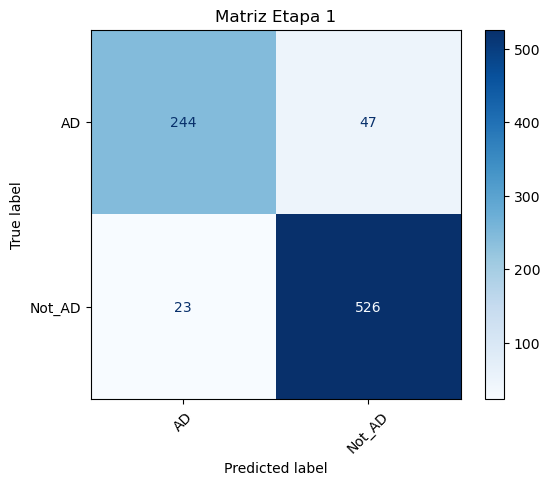

              precision    recall  f1-score   support

          AD       0.91      0.84      0.87       291
      Not_AD       0.92      0.96      0.94       549

    accuracy                           0.92       840
   macro avg       0.92      0.90      0.91       840
weighted avg       0.92      0.92      0.92       840



In [ ]:
y_pred_stage1 = final_model_stage1.predict(X_test_stage1, batch_size=32, verbose=1)
y_pred_bool_stage1 = np.argmax(y_pred_stage1, axis=1)
print(classification_report(Y_test_stage1, y_pred_bool_stage1))
plot_confusion(Y_test_stage1, y_pred_bool_stage1, labels=["CN", "Not_CN"], title="Matriz Etapa 1")

549/549 [==============================] - 3s 6ms/sample
              precision    recall  f1-score   support

           0       0.58      0.43      0.50       276
           1       0.55      0.68      0.61       273

    accuracy                           0.56       549
   macro avg       0.56      0.56      0.55       549
weighted avg       0.56      0.56      0.55       549



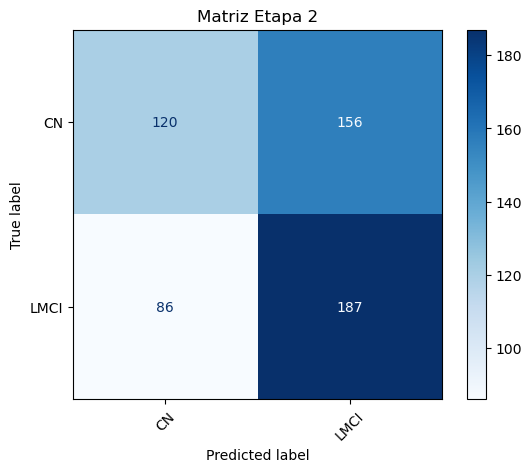

              precision    recall  f1-score   support

          CN       0.58      0.43      0.50       276
        LMCI       0.55      0.68      0.61       273

    accuracy                           0.56       549
   macro avg       0.56      0.56      0.55       549
weighted avg       0.56      0.56      0.55       549



In [ ]:
y_pred_stage2 = final_model_stage2.predict(X_test_stage2, batch_size=32, verbose=1)
y_pred_bool_stage2 = np.argmax(y_pred_stage2, axis=1)
print(classification_report(Y_test_stage2, y_pred_bool_stage2))
plot_confusion(Y_test_stage2, y_pred_bool_stage2, labels=["AD", "LMCI"], title="Matriz Etapa 2")


🧪 Evaluando Cascada completa (CN vs MCI vs AD)...


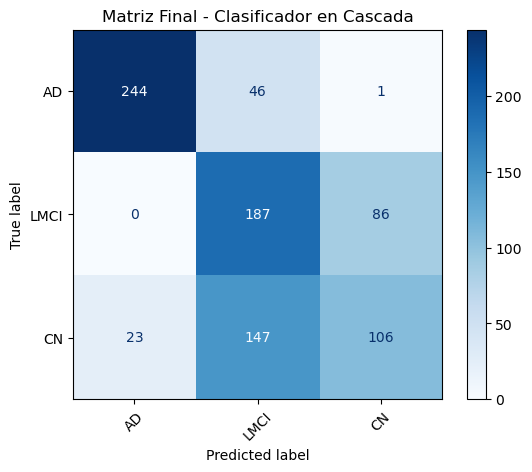

              precision    recall  f1-score   support

          AD       0.91      0.84      0.87       291
        LMCI       0.49      0.68      0.57       273
          CN       0.55      0.38      0.45       276

    accuracy                           0.64       840
   macro avg       0.65      0.64      0.63       840
weighted avg       0.66      0.64      0.64       840



In [ ]:
# -------------------- VALIDACIÓN CASCADA COMPLETA --------------------
print("\n🧪 Evaluando Cascada completa (CN vs MCI vs AD)...")

# Cargar todas las imágenes para evaluación final
data_path_test = "DATA_BASE\\DATA_BASE_TEST\\IMAGES_PREPROCESSED_TEST\\CLEAN"
categories = ["CN", "LMCI", "AD"]
img_size = 224

X_all = []
Y_all = []

label_map = {"CN": 0, "LMCI": 1, "AD": 2}
for cat in categories:
    path = os.path.join(data_path_test, cat)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img))
        if img_array is not None:
            resized = cv2.resize(img_array, (img_size, img_size))
            X_all.append(resized)
            Y_all.append(label_map[cat])

X_all = np.array(X_all).reshape(-1, img_size, img_size, 3) / 255.0
Y_all = np.array(Y_all)

# Predicción en cascada
y_pred_final = []
for img in X_all:
    img_exp = np.expand_dims(img, axis=0)
    pred1 = final_model_stage1.predict(img_exp)
    if np.argmax(pred1) == 0:
        y_pred_final.append(0)  # CN
    else:
        pred2 = final_model_stage2.predict(img_exp)
        y_pred_final.append(2 if np.argmax(pred2) == 0 else 1)  # AD:2 / LMCI:1

plot_confusion(Y_all, y_pred_final, labels=["CN", "LMCI", "AD"], title="Matriz Final - Clasificador en Cascada")